# Product Design Mining - as a Product Designer, I want to know users' preferences - specifically paint points - , so that I can improve the product

### False positives are more costly, in that they miss critical negative pain points and feedback by seeing them as positive - this informs metric of F 0.5 on Positive class of sentiment being the focus

### False negatives on Negative class are the focus as they miss out on actual negative feedbacks, informing a metric of F2 on Negative class of sentiment

#### Advertisers would care about F1 on both, in that you are looking for negative things to downplay and positive things to upsell

#### Outstanding question:
##### Are we required to build a multiclass classifier for the NLP project with the base dataset? I might be off base, but it looks like the NaNs in what product/brand the tweets are directed at almost 1:1 correspond to all the Neutral sentiment reviews. Predicting the neutral sentiment reviews if you include the direction of the tweet by say, filling the NaN, seems...too easy and...not informative, because it would be so heavily correlated to not referencing a product? Dropping the NaN leaves a brutally small amount of neutral reviews, but I guess I can work with that. 

##### It's also a bit counter seeming to the dataset's theme and any business use cases to predict people going 'meh' about not just a company's product, but about Not a product, or something that it's hard to tell if it is referring to a product, however data entry was done. 

#### It's most of the dataset, this combination of neutral sentiment + NaN product or brand that it's directed at, and it's totally a judgment call on what to do with it, but like...perspective or input when people see this on how you would tackle it?

##### I might have done the query to see that these match up between the two columns wrong and disregard this if so: 

##### # Wherein 1 in sentiment is not having a strong emotion/can't tell, and 2 in direction is a NaN that's been filled 
##### neutrals = [1,2]
##### df[(df[['sentiment','direction']].values == neutrals).all(axis=1)]

##### # Returns 5444, all the neutral sentiments and 5444/5801 of the no product direction values.``

# Imports and reading in data

In [1]:
import keras
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import yellowbrick
import tensorflow as tf
from yellowbrick.text import FreqDistVisualizer
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import spacy
nlp = spacy.load('en_core_web_sm')

# Import the displaCy library
from spacy import displacy

Using TensorFlow backend.
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from sklearn import metrics
import missingno as msno

In [3]:
plt.style.use('seaborn-talk')

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

## Reading in data

In [5]:
# df = pd.read_csv('drive/My Drive/judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',encoding = "ISO-8859-1")

df.head(20)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [6]:
df.isnull().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

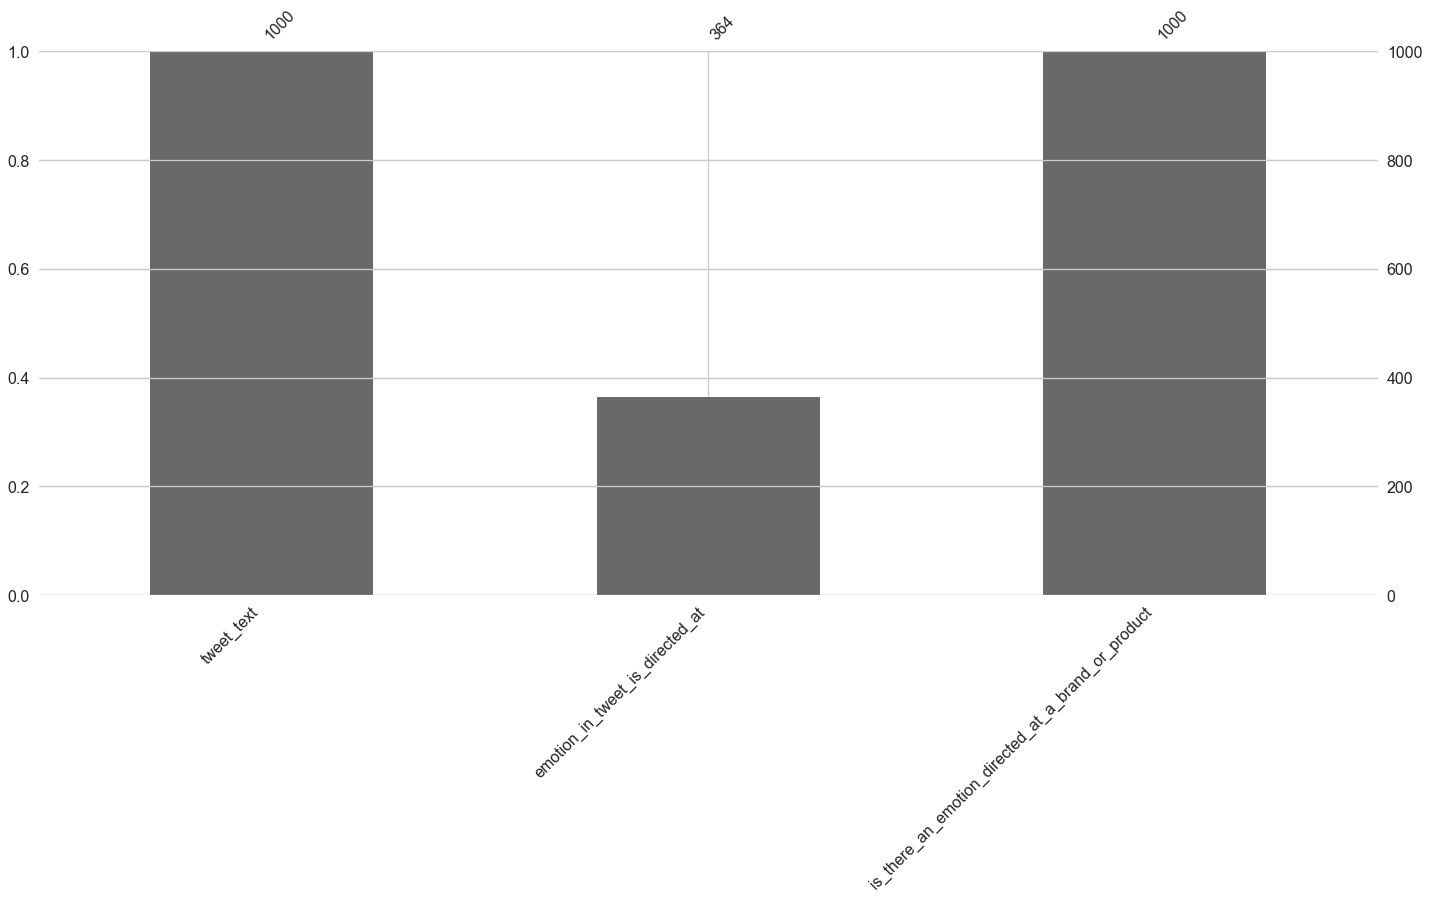

In [7]:
msno.bar(df.sample(1000))

In [8]:
df.dropna(subset=['tweet_text'],inplace=True)

df.isnull().sum()

tweet_text                                               0
emotion_in_tweet_is_directed_at                       5801
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [9]:
df.emotion_in_tweet_is_directed_at.value_counts(dropna=False)

NaN                                5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [10]:
print(5801 / len(df))

0.6380334359876815


In [11]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [12]:
df.fillna('unknown', inplace=True) 

df.isnull().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

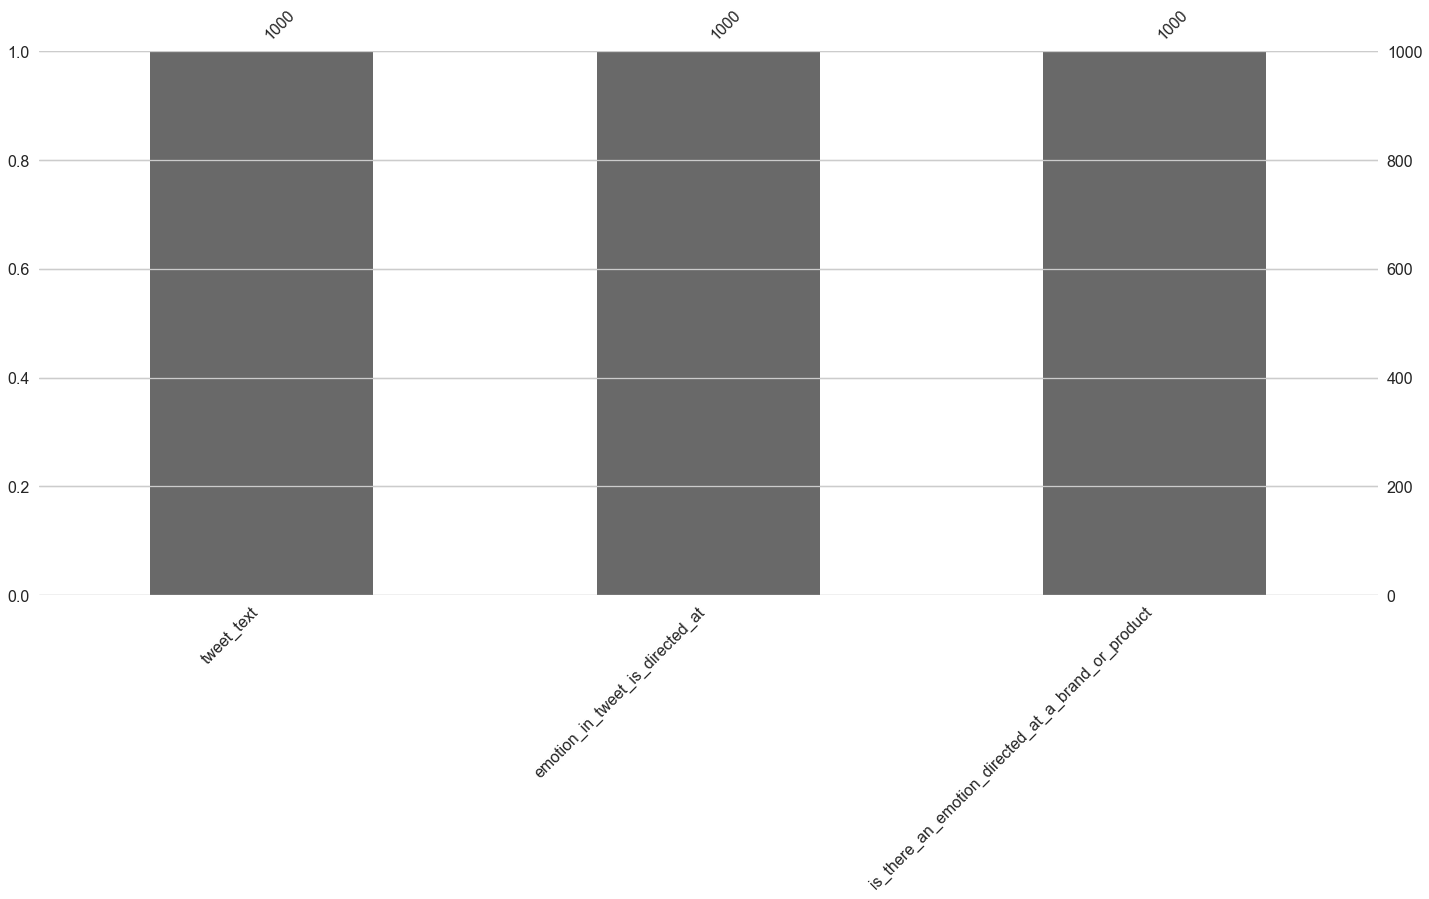

In [13]:
msno.bar(df.sample(1000))

In [14]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

# Preprocessing

## Renaming columns

In [15]:
df = df.rename(columns={"tweet_text": "text", "emotion_in_tweet_is_directed_at":"direction", "is_there_an_emotion_directed_at_a_brand_or_product":"sentiment"})

df

,text,direction,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",unknown,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",unknown,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,unknown,No emotion toward brand or product


In [16]:
df.sentiment.value_counts(dropna=False)

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [17]:
df.direction.value_counts(dropna=False)

unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: direction, dtype: int64

### Mapping sentiment to 0 for negative, 1 for neutral-like, 2 for positive

In [18]:
df.sentiment = df.sentiment.map({'Positive emotion': 2, 'No emotion toward brand or product':1, "I can't tell":1, 'Negative emotion': 0})

In [19]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

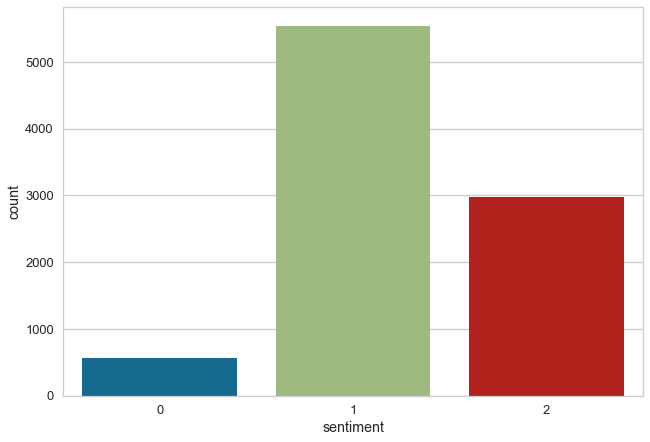

In [20]:
sns.countplot(df.sentiment)

In [21]:
df.direction.value_counts(dropna=False)

unknown                            5801
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: direction, dtype: int64

### Mapping direction of the tweet to 0 for apple and its products/services, 1 for google, 2 for unknown

In [22]:
df.direction = df.direction.map({'iPad':0, 'Apple':0,'iPad or iPhone App':0,'iPhone':0,'Other Apple product or service':0,'Google':1,'Other Google product or service':1,'Android App':1,'Android':1, 'unknown':2})

In [23]:
df.direction.value_counts(dropna=False)

2    5801
0    2409
1     882
Name: direction, dtype: int64

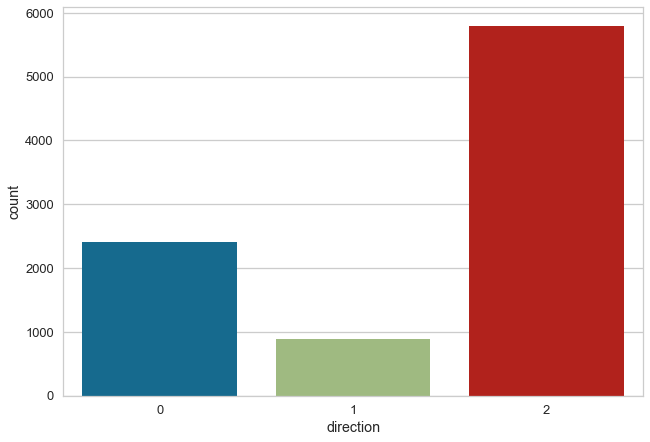

In [24]:
sns.countplot(df.direction)

In [25]:
#Wherein 1 in sentiment is not having a strong emotion/can't tell, and 2 in direction is a NaN that's been filled 
neutrals = [1,2]
df[(df[['sentiment','direction']].values == neutrals).all(axis=1)]

,text,direction,sentiment
5,@teachntech00 New iPad Apps For #SpeechTherapy...,2,1
16,Holler Gram for iPad on the iTunes App Store -...,2,1
32,"Attn: All #SXSW frineds, @mention Register fo...",2,1
33,Anyone at #sxsw want to sell their old iPad?,2,1
34,Anyone at #SXSW who bought the new iPad want ...,2,1
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",2,1
9089,"Wave, buzz... RT @mention We interrupt your re...",2,1
9090,"Google's Zeiger, a physician never reported po...",2,1
9091,Some Verizon iPhone customers complained their...,2,1


In [26]:
len(df)

9092

In [27]:
df.sentiment.value_counts(dropna=False)

1    5544
2    2978
0     570
Name: sentiment, dtype: int64

In [28]:
df.direction.value_counts(dropna=False)

2    5801
0    2409
1     882
Name: direction, dtype: int64

In [29]:
df.query('@neutrals[0] != sentiment and @neutrals[1] == direction').shape[0]

357

# Shows that the NaNs of direction were entered as a neutral sentiment

In [30]:
5801 - 357

5444

# General text preprocessing function

In [31]:
def preprocess(text):
    text = text.str.replace("(<br/>)", "")
    text = text.str.replace('(<a).*(>).*(</a>)', '')
    text = text.str.replace('(&amp)', '')
    text = text.str.replace('(&gt)', '')
    text = text.str.replace('(&lt)', '')
    text = text.str.replace('(\xa0)', ' ')  
    return text

clean_df = df 
clean_df['text'] = preprocess(clean_df['text'])

clean_df['text']

0       .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
3       @sxsw I hope this year's festival isn't as cra...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
                              ...                        
9088                        Ipad everywhere. #SXSW {link}
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: text, Length: 9092, dtype: object

# Creating new features

In [32]:
clean_df['tweet_len'] = clean_df['text'].astype(str).apply(len)
clean_df['tweet_words'] = clean_df['text'].apply(lambda x: len(str(x).split()))

In [33]:
def tweet_special_count(string, character):
    '''docstring'''
    w = string.split()
    
    char = [word for word in w if word.startswith(character)]
    
    return len(char)

In [34]:
clean_df['hash_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '#'))
clean_df['mention_cnt'] = clean_df['text'].apply(lambda x: tweet_special_count(x, '@'))
clean_df['capital_words'] = clean_df['text'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)))
clean_df['excl_q_marks'] = clean_df['text'].apply(lambda x: len(re.findall(r'!|\?', x)))
clean_df.head()



,text,direction,sentiment,tweet_len,tweet_words,hash_cnt,mention_cnt,capital_words,excl_q_marks
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,0,0,127,23,2,0,1,1
1,@jessedee Know about @fludapp ? Awesome iPad/i...,0,2,139,22,1,2,1,1
2,@swonderlin Can not wait for #iPad 2 also. The...,0,2,79,15,2,1,1,0
3,@sxsw I hope this year's festival isn't as cra...,0,0,82,15,1,1,0,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,2,127,17,1,1,1,0


In [35]:
clean_df.columns

Index(['text', 'direction', 'sentiment', 'tweet_len', 'tweet_words',
       'hash_cnt', 'mention_cnt', 'capital_words', 'excl_q_marks'],
      dtype='object')

In [36]:
# clean_df['doc'] = df['text'].apply(lambda x: nlp(x))

# clean_df.head()

In [37]:
# from collections import Counter
# tokens = nlp(''.join(str(df.text.tolist())))
# items = [x.text for x in tokens.ents]
# Counter(items).most_common(20)

In [38]:
# products = []
# for ent in tokens.ents:
#     if ent.label_ == 'PRODUCT':
#         products.append(ent.text)
        
# prdct_cnt = Counter(products).most_common(20)
# df_prod = pd.DataFrame(prdct_cnt, columns =['text', 'count'])

# df_prod.plot.barh(x='text', y='count', title="Most Common Products Mentioned").invert_yaxis()
# plt.show()
# plt.savefig('common_products.png')

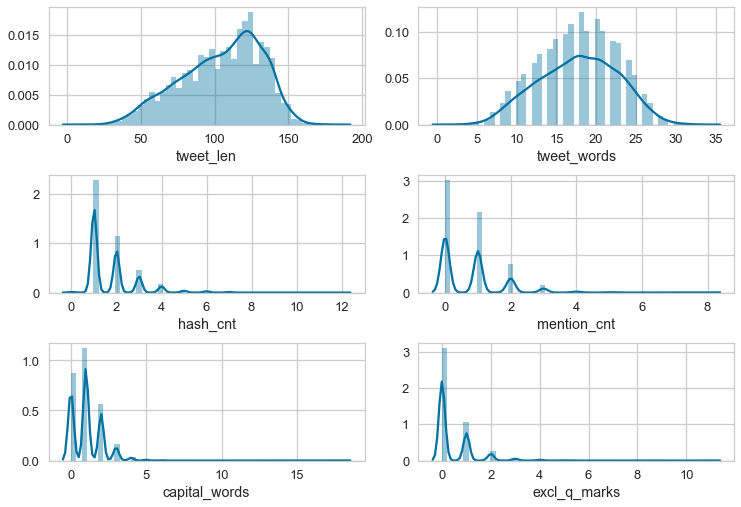

In [39]:
fig, axs = plt.subplots(ncols=2, nrows=3)
sns.distplot(clean_df['tweet_len'], ax=axs[0][0])
sns.distplot(clean_df['tweet_words'], ax=axs[0][1])
sns.distplot(clean_df['hash_cnt'], ax=axs[1][0])
sns.distplot(clean_df['mention_cnt'], ax=axs[1][1])
sns.distplot(clean_df['capital_words'], ax=axs[2][0])
sns.distplot(clean_df['excl_q_marks'], ax=axs[2][1])

plt.tight_layout()

In [40]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
clean_df['text'].apply(tt.tokenize)

0       [., @wesley83, I, have, a, 3G, iPhone, ., Afte...
1       [@jessedee, Know, about, @fludapp, ?, Awesome,...
2       [@swonderlin, Can, not, wait, for, #iPad, 2, a...
3       [@sxsw, I, hope, this, year's, festival, isn't...
4       [@sxtxstate, great, stuff, on, Fri, #SXSW, :, ...
                              ...                        
9088             [Ipad, everywhere, ., #SXSW, {, link, }]
9089    [Wave, ,, buzz, ..., RT, @mention, We, interru...
9090    [Google's, Zeiger, ,, a, physician, never, rep...
9091    [Some, Verizon, iPhone, customers, complained,...
9092    [, Ï, ¡, , Ïà, , ü_, , , Ê, , , Î, , ...
Name: text, Length: 9092, dtype: object

In [41]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/michaelburak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [42]:
clean_df['text'] = [word.lower() for word in clean_df['text'] if word.lower() not in stopwords_list]

clean_df['text']

0       .@wesley83 i have a 3g iphone. after 3 hrs twe...
1       @jessedee know about @fludapp ? awesome ipad/i...
2       @swonderlin can not wait for #ipad 2 also. the...
3       @sxsw i hope this year's festival isn't as cra...
4       @sxtxstate great stuff on fri #sxsw: marissa m...
                              ...                        
9088                        ipad everywhere. #sxsw {link}
9089    wave, buzz... rt @mention we interrupt your re...
9090    google's zeiger, a physician never reported po...
9091    some verizon iphone customers complained their...
9092    ï¡ïàü_êîò£áââ_£â_ûârt @...
Name: text, Length: 9092, dtype: object

## TO DO: T-sne

In [43]:
# from wordcloud import WordCloud

In [44]:
# wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# wordcloud.generate(clean_df['text'].to_string())

# wordcloud.to_image()

In [45]:
#LDA would go here

# Modeling - needs model comparison/tuning

In [46]:
from sklearn_pandas import DataFrameMapper, cross_val_score
from sklearn.ensemble import RandomForestClassifier

In [47]:
mapper = DataFrameMapper([
     ('text', TfidfVectorizer()),
     ('direction', None),
     ('tweet_len', None),
     ('tweet_words', None),
    ('hash_cnt', None),
    ('mention_cnt', None),
    ('capital_words', None),
    ('excl_q_marks', None)
 ])

In [48]:
X = mapper.fit_transform(clean_df)

In [49]:
X

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 2., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [50]:
clean_df.direction.value_counts(dropna=False)

2    5801
0    2409
1     882
Name: direction, dtype: int64

In [51]:
df_posneg = clean_df.copy()
df_posneg = df_posneg[df_posneg.direction !=2]

df_posneg.direction.value_counts(dropna=False)

0    2409
1     882
Name: direction, dtype: int64

In [52]:
mapped_pn = mapper.fit_transform(df_posneg)
mapped_pn

array([[0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 2., 1., 1.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [53]:
X_posneg = mapped_pn
y_posneg = df_posneg['sentiment']

# Train test splits

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
y = clean_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

## Train test split for positive and negative only

In [55]:
X_train_posneg, X_test_posneg, y_train_posneg, y_test_posneg = train_test_split(X_posneg, y_posneg, test_size=0.33, random_state=42,stratify=y_posneg)

# PCA train_test split

In [56]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# X_pca = X
# pca.fit(X_pca)

# X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.33, random_state=42,stratify=y)

## Comparing class balance between full dataset and dataset without NaN products

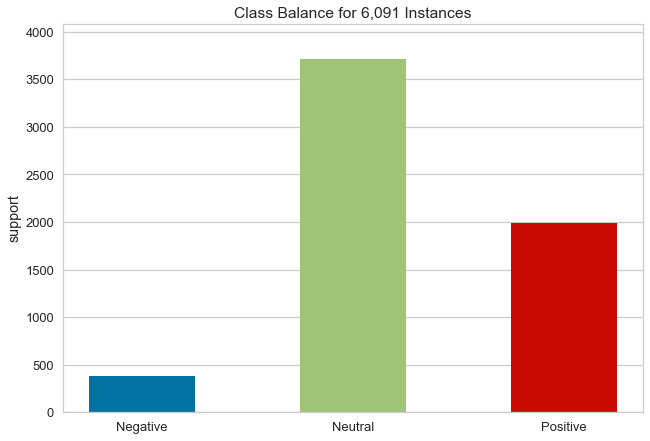

In [57]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train)        # Fit the data to the visualizer
visualizer.show()

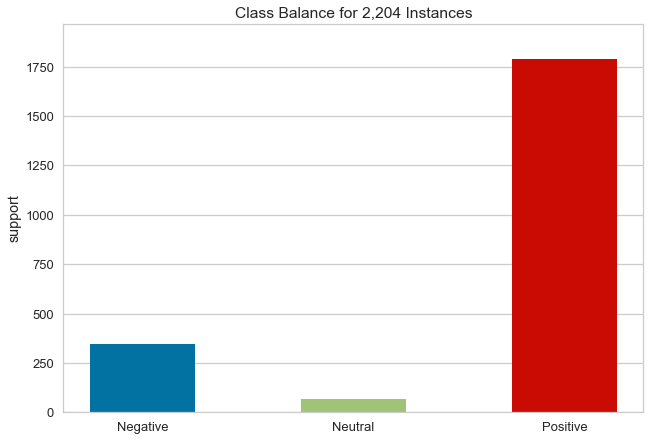

In [58]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train_posneg)        # Fit the data to the visualizer
visualizer.show()

# Multinomial NB Base Model for Comparison

In [59]:
model = MultinomialNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [60]:
print(metrics.classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       188
           1       0.69      1.00      0.81      1830
           2       0.86      0.30      0.45       983

    accuracy                           0.71      3001
   macro avg       0.52      0.43      0.42      3001
weighted avg       0.70      0.71      0.64      3001



/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
from sklearn.metrics import hamming_loss
print(hamming_loss(y_test, y_pred))

0.2935688103965345


In [62]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, y_pred))

0.30556364687950544


In [63]:
from sklearn.metrics import fbeta_score

def fscores(y_test=y_test, y_pred=y_pred):
    f05 = fbeta_score(y_test, y_pred, average=None, beta=0.5, labels=[0,1,2])
    f2 = fbeta_score(y_test, y_pred, average=None, beta=2.0, labels=[0,1,2])
    for idx,c in enumerate(f05):
        print (f'F0.5 of {idx} class is {f05[idx]}')
        print (f'F2 of {idx} class is {f2[idx]}')
        print ('-----------')

fscores()

# from sklearn.metrics import fbeta_score
# f05 = fbeta_score(y_test, y_pred, average=None, beta=0.5, labels=[0,1,2])
# f2 = fbeta_score(y_test, y_pred, average=None, beta=2.0, labels=[0,1,2])

# for idx,c in enumerate(f05):
#     print (f'F0.5 of {idx} class is {fb[idx]}')
#     print (f'F2 of {idx} class is {f2[idx]}')
#     print ('-----------')

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.7321285140562249
F2 of 1 class is 0.9137844611528821
-----------
F0.5 of 2 class is 0.6273764258555133
F2 of 2 class is 0.34712482468443195
-----------


## Modeling without no product tweets

In [64]:
model = MultinomialNB()
model.fit(X_train_posneg, y_train_posneg)
y_pred_posneg = model.predict(X_test_posneg)

In [65]:
print(metrics.classification_report(y_test_posneg,y_pred_posneg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       171
           1       0.00      0.00      0.00        33
           2       0.81      1.00      0.90       883

    accuracy                           0.81      1087
   macro avg       0.27      0.33      0.30      1087
weighted avg       0.66      0.81      0.73      1087



/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [66]:
from sklearn.metrics import hamming_loss
print(hamming_loss(y_test_posneg, y_pred_posneg))

0.18767249310027598


In [67]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test_posneg, y_pred_posneg))

0.0


In [68]:
fscores(y_test_posneg, y_pred_posneg)

F0.5 of 0 class is 0.0
F2 of 0 class is 0.0
-----------
F0.5 of 1 class is 0.0
F2 of 1 class is 0.0
-----------
F0.5 of 2 class is 0.8440068820493213
F2 of 2 class is 0.9558345962329508
-----------


# SMOTE on full dataset

In [69]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from imblearn.over_sampling import SMOTE
# import six 
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)
print (y_train.value_counts() , np.bincount(y_train_res))

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, c

1    3714
2    1995
0     382
Name: sentiment, dtype: int64 [3714 3714 3714]


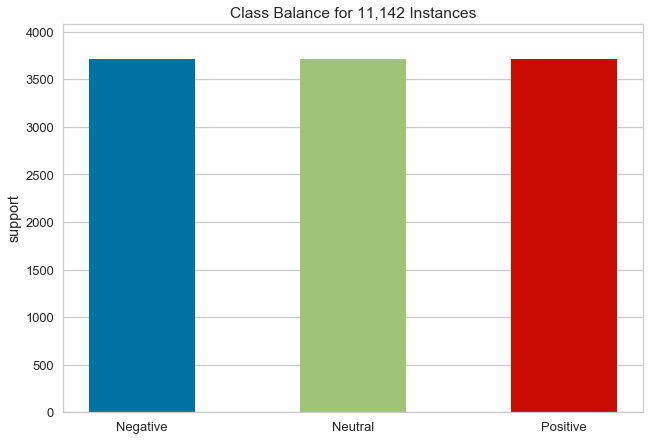

In [70]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train_res)        # Fit the data to the visualizer
visualizer.show()

# Multinomial NB on SMOTE

In [71]:
sm_model = MultinomialNB()
sm_model.fit(x_train_res, y_train_res)
y_pred_smote = sm_model.predict(X_test)
print(metrics.classification_report(y_test,y_pred_smote))

              precision    recall  f1-score   support

           0       0.36      0.64      0.46       188
           1       0.88      0.94      0.91      1830
           2       0.89      0.66      0.76       983

    accuracy                           0.83      3001
   macro avg       0.71      0.75      0.71      3001
weighted avg       0.85      0.83      0.83      3001



In [72]:
print(hamming_loss(y_test, y_pred_smote))

0.1709430189936688


In [73]:
print(cohen_kappa_score(y_test, y_pred_smote))

0.6702313651770689


In [74]:
fscores(y_test, y_pred_smote)

F0.5 of 0 class is 0.398936170212766
F2 of 0 class is 0.5550416281221092
-----------
F0.5 of 1 class is 0.8941567893532958
F2 of 1 class is 0.9280241717923815
-----------
F0.5 of 2 class is 0.8344063868143189
F2 of 2 class is 0.6957268627872021
-----------


# SMOTE on data w/o NaN products

In [75]:
sm = SMOTE(random_state=12)
x_train_pn_res, y_train_pn_res = sm.fit_sample(X_train_posneg, y_train_posneg)
print (y_train_posneg.value_counts() , np.bincount(y_train_pn_res))

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


2    1789
0     348
1      67
Name: sentiment, dtype: int64 [1789 1789 1789]


/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


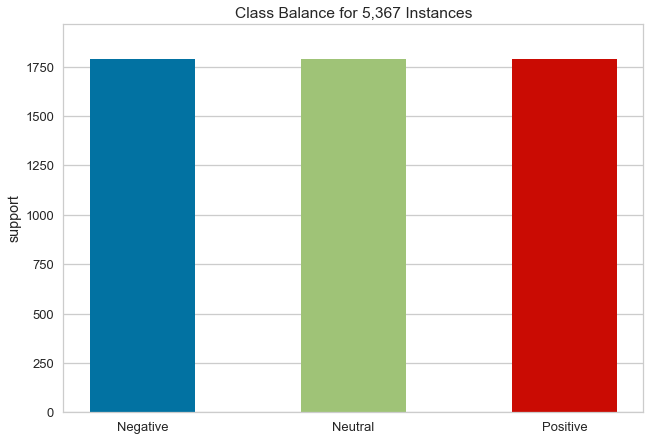

In [76]:
from yellowbrick.target import ClassBalance
visualizer = ClassBalance(labels=["Negative", "Neutral", "Positive"])

visualizer.fit(y_train_pn_res)        # Fit the data to the visualizer
visualizer.show()

In [77]:
sm_pn_model = MultinomialNB()
sm_pn_model.fit(x_train_pn_res, y_train_pn_res)
y_pred_pn_smote = sm_pn_model.predict(X_test_posneg)
print(metrics.classification_report(y_test_posneg,y_pred_pn_smote))

              precision    recall  f1-score   support

           0       0.41      0.65      0.50       171
           1       0.08      0.21      0.12        33
           2       0.92      0.76      0.83       883

    accuracy                           0.73      1087
   macro avg       0.47      0.54      0.48      1087
weighted avg       0.82      0.73      0.76      1087



In [78]:
print(hamming_loss(y_test_posneg, y_pred_pn_smote))

0.27414903403863844


In [79]:
print(cohen_kappa_score(y_test_posneg, y_pred_pn_smote))

0.3392124223805211


In [80]:
fscores(y_test_posneg, y_pred_pn_smote)

F0.5 of 0 class is 0.44082605242255757
F2 of 0 class is 0.5805439330543932
-----------
F0.5 of 1 class is 0.0909090909090909
F2 of 1 class is 0.1590909090909091
-----------
F0.5 of 2 class is 0.8849907676074915
F2 of 2 class is 0.7877436017844566
-----------


# Conclusion: Loses predictive power on the neutral class but increases greatly on the other two classes, except with Kappa

# Outlier detection approaches

# Multilabel classification? - needs to include SMOTE

In [86]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()

y=pd.DataFrame(mlb.fit_transform(clean_df[['direction','sentiment']].values), columns=mlb.classes_, index=clean_df.index)

In [87]:
X = clean_df.drop(['direction', 'sentiment'],axis=1)

In [88]:

X = mapper.fit_transform(X)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [90]:
from skmultilearn.problem_transform import ClassifierChain

from skmultilearn.problem_transform import LabelPowerset



# initialize LabelPowerset multi-label classifier with a RandomForest
classifier = ClassifierChain(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [91]:
print(hamming_loss(y_test, predictions))

0.18416083527712984


In [92]:
# print(cohen_kappa_score(y_test, predictions))

In [93]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

# initialize Binary Relevance multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

classifier = BinaryRelevance(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

In [94]:
print(hamming_loss(y_test, predictions))

0.18427190936354548


In [95]:
# print(cohen_kappa_score(y_test, predictions))

In [96]:
from scipy import sparse

X_sparse = sparse.csr_matrix(X)

X_sparse

<9092x9780 sparse matrix of type '<class 'numpy.float64'>'
	with 165439 stored elements in Compressed Sparse Row format>

In [97]:
y_sparse = sparse.csr_matrix(y)

y_sparse

<9092x3 sparse matrix of type '<class 'numpy.longlong'>'
	with 17462 stored elements in Compressed Sparse Row format>

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y_sparse, test_size=0.33, random_state=42,stratify=y)

In [99]:
from skmultilearn.adapt import MLkNN

classifier = MLkNN(k=3)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)

/Users/michaelburak/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_neighbors=3 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [100]:
print(hamming_loss(y_test, predictions))

0.2539153615461513


In [101]:
# print(cohen_kappa_score(y_test, predictions))

In [102]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC

# initialize Binary Relevance multi-label classifier
# with an SVM classifier
# SVM in scikit only supports the X matrix in sparse representation

classifier = BinaryRelevance(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(hamming_loss(y_test, predictions))

0.18271687215372653


In [103]:
from skmultilearn.problem_transform import ClassifierChain

from skmultilearn.problem_transform import LabelPowerset
from sklearn.ensemble import RandomForestClassifier

# initialize LabelPowerset multi-label classifier with a RandomForest
classifier = ClassifierChain(
    classifier = RandomForestClassifier(n_estimators=100),
    require_dense = [False, True]
)

# train
classifier.fit(X_train, y_train)

# predict
predictions = classifier.predict(X_test)
print(hamming_loss(y_test, predictions))

0.18371653893146728


In [104]:
# print(cohen_kappa_score(y_test, predictions))